In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

%matplotlib inline 

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
dataset = pd.read_csv('TSLA.csv')
dataset.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
data = dataset['Open'].values
data = data.reshape(-1,1)

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [5]:
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)
print(len(data_norm))

2227


## Define Hyperparameters

In [19]:
##### Define Hyperparameters #####
epochs = 500
batch_size = 10
learning_rate = 0.01
num_layers = 1
h_layer_size = 512
dropout = 0.2
num_seq = 10
num_units  = 200
input_size = 1
tf.reset_default_graph()

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [20]:
def window(data, num_seq):
    data_ = []
    
    i = 0
    
    for i in range(len(data) - num_seq):
        data_.append(data[i:i+num_seq])

    return data_

data_n = window(data_norm, num_seq)
len(data_n)

2217

In [21]:
len(data_n[0][0])

1

In [22]:
data_n = np.array(data_n)
X_train = data_n[:1000,:-1,:]
Y_train = data_n[:1000,-1,:]

X_test = data_n[1000:2000,:-1,:]
Y_test = data_n[1000:2000,-1,:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1000, 9, 1)
(1000, 1)
(1000, 9, 1)
(1000, 1)


## Define Placeholders

In [23]:
inputs = tf.placeholder(tf.float32, [None, num_seq-1, input_size])
outputs = tf.placeholder(tf.float32, [None, input_size])

# TensorFlow Model

<p style="font-size:15px">I'm going to use an LSTM model. I made this choice because I think I want to use this for my final project so this is good practice. 

In [24]:
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=num_units, activation=tf.nn.relu) for layer in range(num_layers)]

multi_layer = tf.contrib.rnn.MultiRNNCell(layers)

lstm_out, states = tf.nn.dynamic_rnn(multi_layer, inputs, dtype=tf.float32)

stacked_outputs = tf.layers.dense(tf.reshape(lstm_out, [-1, num_units]), input_size)

out = tf.reshape(stacked_outputs, [-1, num_seq-1, input_size])
out = out[:,num_seq-2,:]


loss = tf.reduce_mean(tf.square(out-outputs)) #MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)


## Training

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        sess.run(training_op, feed_dict={inputs:X_train, outputs:Y_train})
    
        if epoch % 100 == 0:
            acc_train = loss.eval(feed_dict={inputs: X_train, outputs: Y_train}) 
            acc_valid = loss.eval(feed_dict={inputs:X_test, outputs: Y_test}) 
            
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(epoch, acc_train, acc_valid))
            
    training_prediction = sess.run(out, feed_dict={inputs:X_train})
    testing_preidction = sess.run(out, feed_dict={inputs:X_test})


0.00 epochs: MSE train/valid = 0.015568/0.130550
100.00 epochs: MSE train/valid = 0.000203/0.000843
200.00 epochs: MSE train/valid = 0.000168/0.000947
300.00 epochs: MSE train/valid = 0.000149/0.001648
400.00 epochs: MSE train/valid = 0.000141/0.001339


In [ ]:
training_prediction.shape
print(training_prediction[:100])

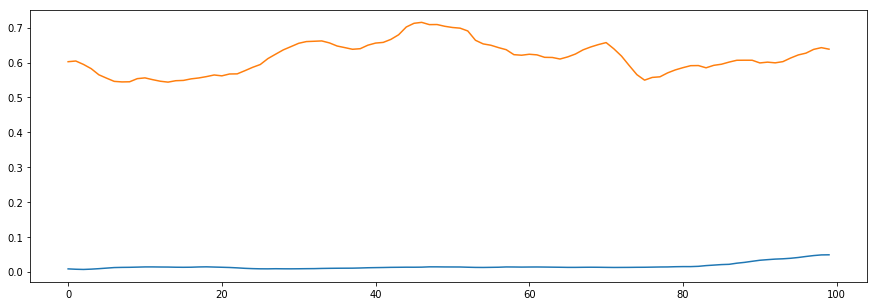

In [26]:
plt.figure(figsize=(15, 5));
#plt.subplot(1,2,1);

plt.plot(training_prediction[:100])
plt.plot(testing_preidction[:100])